In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")

    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    
    ### here are my customized features
    # use KBinsDiscretizer to discretize quantitative features
    if(not test):
        est = KBinsDiscretizer(n_bins=[4, 3], encode='ordinal', strategy='uniform')
        X_dis = est.fit_transform(movie_data[["word_count", "punc_count"]])
        fitted_transformations.append(est)
    else:
        X_dis = fitted_transformations[2].transform(movie_data[["word_count", "punc_count"]])

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_dis])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=713)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5          89           5
6         112           9
7         132           9
8         163           7
9          43           5
Size of combined bag of words and new quantitative variables matrix:
(25000, 131074)
(25000, 131074)
Shape of X_train and X_test:
(20000, 131074)
(5000, 131074)
Shape of y_train and y_test:
(20000,)
(5000,)
Shape of X_raw_train and X_raw_test:
(20000, 5)
(5000, 5)
SUCCESS!
Number of fits stored in `fitted_transformations` list: 
4


### Create Ridge Regression Classifiers with different params

In [21]:
from sklearn import linear_model

# Create Models with different parameters

rdg_0 = linear_model.RidgeClassifier()
rdg_0.fit(X_train, y_train)

rdg_0_performance_train = BinaryClassificationPerformance(rdg_0.predict(X_train), y_train, 'train_0(1)')
rdg_0_performance_train.compute_measures()
print(rdg_0_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'train_0(1)'}


In [22]:
rdg_1 = linear_model.RidgeClassifier(alpha=5)
rdg_1.fit(X_train, y_train)

rdg_1_performance_train = BinaryClassificationPerformance(rdg_1.predict(X_train), y_train, 'train_1(5)')
rdg_1_performance_train.compute_measures()
print(rdg_1_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'train_1(5)'}


In [23]:
rdg_2 = linear_model.RidgeClassifier(alpha=40)
rdg_2.fit(X_train, y_train)

rdg_2_performance_train = BinaryClassificationPerformance(rdg_2.predict(X_train), y_train, 'train_2(40)')
rdg_2_performance_train.compute_measures()
print(rdg_2_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'train_2(40)'}


In [24]:
rdg_3 = linear_model.RidgeClassifier(alpha=300)
rdg_3.fit(X_train, y_train)

rdg_3_performance_train = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'train_3(300)')
rdg_3_performance_train.compute_measures()
print(rdg_3_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'train_3(300)'}


In [25]:
rdg_4 = linear_model.RidgeClassifier(alpha=2400)
rdg_4.fit(X_train, y_train)

rdg_4_performance_train = BinaryClassificationPerformance(rdg_4.predict(X_train), y_train, 'train_4(2400)')
rdg_4_performance_train.compute_measures()
print(rdg_4_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'train_4(2400)'}


In [26]:
rdg_5 = linear_model.RidgeClassifier(alpha=19200)
rdg_5.fit(X_train, y_train)

rdg_5_performance_train = BinaryClassificationPerformance(rdg_5.predict(X_train), y_train, 'train_5(19200)')
rdg_5_performance_train.compute_measures()
print(rdg_5_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9972, 'TN': 9994, 'FP': 10, 'FN': 24, 'Accuracy': 0.9983, 'Precision': 0.9989981967541575, 'Recall': 0.9975990396158463, 'desc': 'train_5(19200)'}


In [27]:
rdg_6 = linear_model.RidgeClassifier(alpha=160000)
rdg_6.fit(X_train, y_train)

rdg_6_performance_train = BinaryClassificationPerformance(rdg_6.predict(X_train), y_train, 'train_6(160000)')
rdg_6_performance_train.compute_measures()
print(rdg_6_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9787, 'TN': 9853, 'FP': 151, 'FN': 209, 'Accuracy': 0.982, 'Precision': 0.9848057959347958, 'Recall': 0.9790916366546618, 'desc': 'train_6(160000)'}


In [28]:
rdg_7 = linear_model.RidgeClassifier(alpha=1280000)
rdg_7.fit(X_train, y_train)

rdg_7_performance_train = BinaryClassificationPerformance(rdg_7.predict(X_train), y_train, 'train_7(1280000)')
rdg_7_performance_train.compute_measures()
print(rdg_7_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9398, 'TN': 9611, 'FP': 393, 'FN': 598, 'Accuracy': 0.95045, 'Precision': 0.9598610969257482, 'Recall': 0.9401760704281713, 'desc': 'train_7(1280000)'}


### ROC plot to compare performance of various alpha parameter of RidgeClassifier

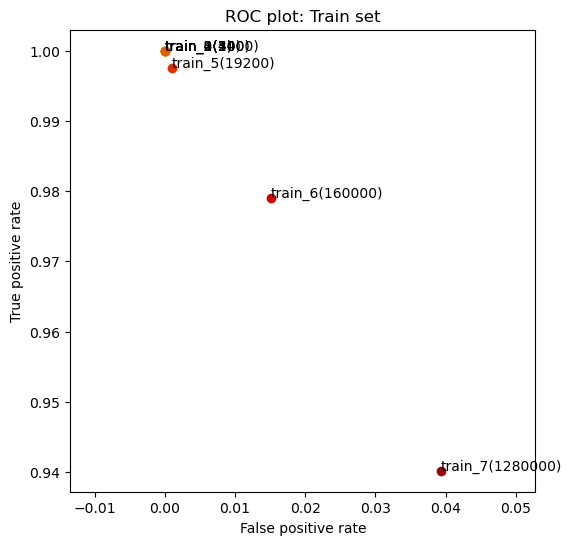

In [56]:
fits = [rdg_0_performance_train, rdg_1_performance_train, rdg_2_performance_train, rdg_3_performance_train, rdg_4_performance_train, rdg_5_performance_train, rdg_6_performance_train, rdg_7_performance_train]
plot_colors = ["black", "#FFBA08", "#FAA307", "#F48C06", "#E85D04", "#DC2F02", "#D00000", "#9D0208"]

plt.figure(figsize=(6,6))
for i, fit in enumerate(fits):
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'o', color=plot_colors[i])
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Look at performance on the test set

### MODEL: Ridge Regression Classifier

In [39]:
rdg_0_performance_test = BinaryClassificationPerformance(rdg_0.predict(X_test), y_test, 'test_0(1)')
rdg_0_performance_test.compute_measures()
print(rdg_0_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2068, 'TN': 2008, 'FP': 488, 'FN': 436, 'Accuracy': 0.8152, 'Precision': 0.809076682316119, 'Recall': 0.8258785942492013, 'desc': 'test_0(1)'}


In [40]:
rdg_1_performance_test = BinaryClassificationPerformance(rdg_1.predict(X_test), y_test, 'test_1(5)')
rdg_1_performance_test.compute_measures()
print(rdg_1_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2068, 'TN': 2009, 'FP': 487, 'FN': 436, 'Accuracy': 0.8154, 'Precision': 0.8093933463796478, 'Recall': 0.8258785942492013, 'desc': 'test_1(5)'}


In [41]:
rdg_2_performance_test = BinaryClassificationPerformance(rdg_2.predict(X_test), y_test, 'test_2(40)')
rdg_2_performance_test.compute_measures()
print(rdg_2_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2071, 'TN': 2012, 'FP': 484, 'FN': 433, 'Accuracy': 0.8166, 'Precision': 0.8105675146771038, 'Recall': 0.827076677316294, 'desc': 'test_2(40)'}


In [42]:
rdg_3_performance_test = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'test_3(300)')
rdg_3_performance_test.compute_measures()
print(rdg_3_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2090, 'TN': 2029, 'FP': 467, 'FN': 414, 'Accuracy': 0.8238, 'Precision': 0.8173640985529917, 'Recall': 0.8346645367412141, 'desc': 'test_3(300)'}


In [43]:
rdg_4_performance_test = BinaryClassificationPerformance(rdg_4.predict(X_test), y_test, 'test_4(2400)')
rdg_4_performance_test.compute_measures()
print(rdg_4_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2157, 'TN': 2096, 'FP': 400, 'FN': 347, 'Accuracy': 0.8506, 'Precision': 0.8435666797027767, 'Recall': 0.8614217252396166, 'desc': 'test_4(2400)'}


In [44]:
rdg_5_performance_test = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'test_5(19200)')
rdg_5_performance_test.compute_measures()
print(rdg_5_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2244, 'TN': 2179, 'FP': 317, 'FN': 260, 'Accuracy': 0.8846, 'Precision': 0.8762202264740335, 'Recall': 0.8961661341853036, 'desc': 'test_5(19200)'}


In [45]:
rdg_6_performance_test = BinaryClassificationPerformance(rdg_6.predict(X_test), y_test, 'test_6(160000)')
rdg_6_performance_test.compute_measures()
print(rdg_6_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2245, 'TN': 2192, 'FP': 304, 'FN': 259, 'Accuracy': 0.8874, 'Precision': 0.8807375441349549, 'Recall': 0.8965654952076677, 'desc': 'test_6(160000)'}


In [46]:
rdg_7_performance_test = BinaryClassificationPerformance(rdg_7.predict(X_test), y_test, 'test_7(1280000)')
rdg_7_performance_test.compute_measures()
print(rdg_7_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2172, 'TN': 2144, 'FP': 352, 'FN': 332, 'Accuracy': 0.8632, 'Precision': 0.8605388272583201, 'Recall': 0.8674121405750799, 'desc': 'test_7(1280000)'}


### ROC plot to compare performance of various alpha parameter of RidgeClassifier

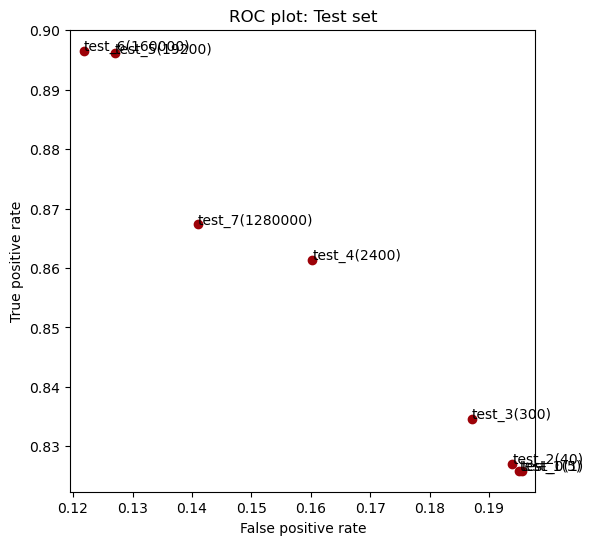

In [57]:
fits = [rdg_0_performance_test, rdg_1_performance_test, rdg_2_performance_test, rdg_3_performance_test, rdg_4_performance_test, rdg_5_performance_test, rdg_6_performance_test, rdg_7_performance_test]

plt.figure(figsize=(6,6))
for i, fit in enumerate(fits):
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'o', color=plot_colors[i])
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.title('ROC plot: Test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

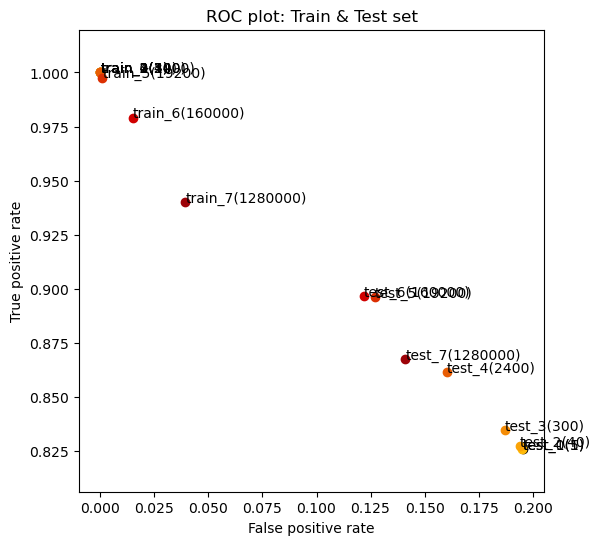

In [58]:
fits = [rdg_0_performance_train, rdg_1_performance_train, rdg_2_performance_train, rdg_3_performance_train, rdg_4_performance_train, rdg_5_performance_train, rdg_6_performance_train, rdg_7_performance_train,
    rdg_0_performance_test, rdg_1_performance_test, rdg_2_performance_test, rdg_3_performance_test, rdg_4_performance_test, rdg_5_performance_test, rdg_6_performance_test, rdg_7_performance_test]

plots_colors = ["black", "#FFBA08", "#FAA307", "#F48C06", "#E85D04", "#DC2F02", "#D00000", "#9D0208",
               "black", "#FFBA08", "#FAA307", "#F48C06", "#E85D04", "#DC2F02", "#D00000", "#9D0208"]

plt.figure(figsize=(6,6))
for i, fit in enumerate(fits):
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'o', color=plots_colors[i])
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.title('ROC plot: Train & Test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()